# Importing needed libraries

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Setting up the project

In [2]:
TEST_FILE = './data/test.csv'
TRAIN_FILE = './data/train.csv'
pd.set_option('display.max_columns', None)

In [3]:
train_data = pd.read_csv(TRAIN_FILE)
MAX_ROWS = len(train_data.index)
MAX_COLS = len(train_data.columns)
train_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,

# Clearing training data

In [4]:
print('Deleting Id column')
train_data = train_data.drop('Id', axis=1)

Deleting Id column


In [5]:
def delete_columns(dataset):
    print('Deleting columns...\n')
    
    for column in dataset.columns:
        nan_count = [nan for nan in dataset[column] if pd.isna(nan)]
        if len(nan_count) > 0.4 * MAX_ROWS:
            print(f'Deleting {column} column')
            dataset = dataset.drop(columns=column)
            
    return dataset

    print(f'\nDeleted a total of {MAX_COLS - len(dataset.columns)} columns')

In [6]:
def replace_nulls(row, train_data=train_data):
    null_count = 0
    for col in row.index:
        if pd.isna(row[col]):
            if pd.api.types.is_numeric_dtype(train_data[col]):
                row[col] = 0
            else:
                row[col] = ''
            null_count += 1
    return row, null_count

train_data = delete_columns(train_data)

print(f'Replacing nulls in {len(train_data)} rows...\n')

total_nulls_replaced = 0
for i in range(len(train_data)):
    train_data.iloc[i], nulls_replaced = replace_nulls(train_data.iloc[i])
    total_nulls_replaced += nulls_replaced

print(f'Total nulls replaced: {total_nulls_replaced}')

Deleting columns...

Deleting Alley column
Deleting MasVnrType column
Deleting FireplaceQu column
Deleting PoolQC column
Deleting Fence column
Deleting MiscFeature column
Replacing nulls in 1460 rows...



/tmp/ipykernel_20/1851572587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[col] = 0
/tmp/ipykernel_20/1851572587.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[col] = ''


Total nulls replaced: 860


# Data Visualization

In [7]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,57.623288,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,34.664304,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,42.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_20/2257136559.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4})


<Axes: xlabel='SalePrice', ylabel='Density'>

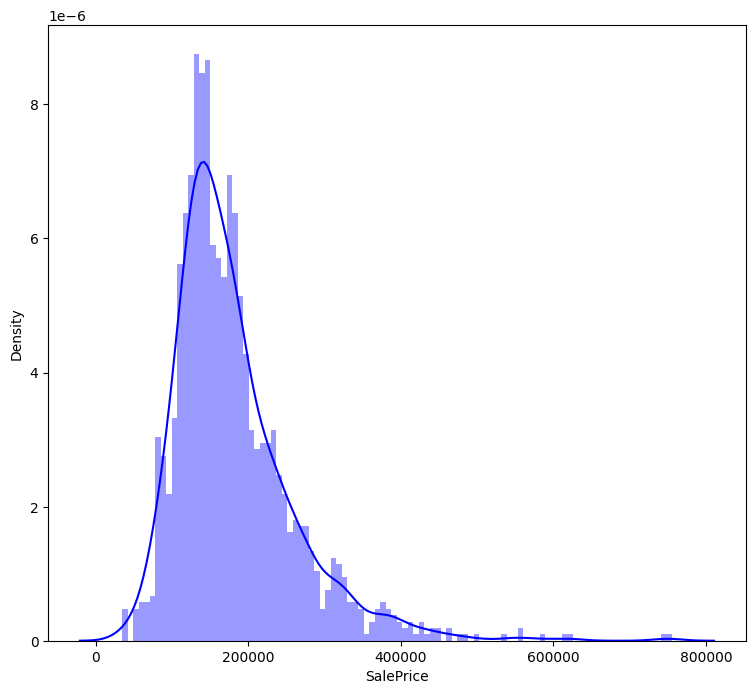

In [9]:
print(train_data['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_data['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4})

# Preparation of training models

In [10]:
def one_hot_encoder(dataset):
    columns = dataset.columns
    types = []
    for column in columns:
        row_list = dataset[column]
        if type(row_list[0]) != str:
            continue
        
        dict_map = dict()
        val = 0
        
        row_list = row_list.reset_index(drop=True)
        
        for value in row_list:
            if value in dict_map.keys():
                continue
            dict_map[value] = val
            val += 1
            
        for i in range(len(row_list)):
            row_list[i] = dict_map[row_list[i]]
            
        dataset[column] = row_list
    return dataset

train_data = one_hot_encoder(train_data)
train_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,65.0,8450,0,0,0,0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0,0,196.0,0,0,0,0,0,0,0,706,0,0,150,856,0,0,0,0,856,854,0,1710,1,0,2,1,3,1,0,8,0,0,0,2003.0,0,2,548,0,0,0,0,61,0,0,0,0,0,2,2008,0,0,208500
1,20,0,80.0,9600,0,0,0,0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1,1,0.0,1,0,1,0,0,1,1,978,0,0,284,1262,0,0,0,0,1262,0,0,1262,0,1,2,0,3,1,1,6,0,1,0,1976.0,0,2,460,0,0,0,298,0,0,0,0,0,0,5,2007,0,0,181500
2,60,0,68.0,11250,0,1,0,0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0,0,162.0,0,0,0,0,0,2,0,486,0,0,434,920,0,0,0,0,920,866,0,1786,1,0,2,1,3,1,0,6,0,1,0,2001.0,0,2,608,0,0,0,0,42,0,0,0,0,0,9,2008,0,0,223500
3,70,0,60.0,9550,0,1,0,0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2,2,0.0,1,0,2,1,1,0,1,216,0,0,540,756,0,1,0,0,961,756,0,1717,1,0,1,0,3,1,0,7,0,1,1,1998.0,1,3,642,0,0,0,0,35,272,0,0,0,0,2,2006,0,1,140000
4,60,0,84.0,14260,0,1,0,0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0,0,350.0,0,0,0,0,0,3,0,655,0,0,490,1145,0,0,0,0,1145,1053,0,2198,1,0,2,1,4,1,0,9,0,1,0,2000.0,0,3,836,0,0,0,192,84,0,0,0,0,0,12,2008,0,0,250000
5,50,0,85.0,14115,0,1,0,0,0,0,4,0,0,0,2,5,5,1993,1995,0,0,0,0,0.0,1,0,3,0,0,0,0,732,0,0,64,796,0,0,0,0,796,566,0,1362,1,0,1,1,1,1,1,5,0,0,0,1993.0,1,2,480,0,0,0,40,30,0,320,0,0,700,10,2009,0,0,143000
6,20,0,75.0,10084,0,0,0,0,0,0,5,0,0,0,1,8,5,2004,2005,0,0,0,0,186.0,0,0,0,2,0,3,0,1369,0,0,317,1686,0,0,0,0,1694,0,0,1694,1,0,2,0,3,1,0,7,0,1,0,2004.0,0,2,636,0,0,0,255,57,0,0,0,0,0,8,2007,0,0,307000
7,60,0,0.0,10382,0,1,0,0,2,0,6,2,0,0,0,7,6,1973,1973,0,0,3,3,240.0,1,0,1,0,0,2,1,859,1,32,216,1107,0,0,0,0,1107,983,0,2090,1,0,2,1,3,1,1,7,0,2,0,1973.0,0,2,484,0,0,0,235,204,228,0,0,0,350,11,2009,0,0,200000
8,50,1,51.0,6120,0,0,0,0,0,0,7,3,0,0,2,7,5,1931,1950,0,0,4,2,0.0,1,0,2,1,0,0,2,0,0,0,952,952,0,1,0,1,1022,752,0,1774,0,0,2,0,2,2,1,8,1,2,1,1931.0,1,2,468,1,0,0,90,0,205,0,0,0,0,4,2008,0,1,129900
9,190,0,50.0,7420,0,0,0,0,2,0,8,3,1,1,3,5,6,1939,1950,0,0,1,1,0.0,1,0,2,1,0,0,0,851,0,0,140,991,0,0,0,0,1077,0,0,1077,1,0,1,0,2,2,1,5,0,2,0,1939.0,0,1,205,2,0,0,0,4,0,0,0,0,0,1,2008,0,0,118000


In [11]:
def split_dataset(dataset, test_ratio=0.25):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_data)
print(f"{len(train_ds_pd)} for training, {len(valid_ds_pd)} for testing")

1086 for training, 374 for testing


In [12]:
def return_tensor(data):
    return np.asarray(data).astype(np.float32)

# Training model

In [13]:
model = keras.Sequential()
model.add(layers.Dense(768, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

label = 'SalePrice'

In [14]:
print(train_ds_pd.shape, train_ds_pd[label].shape)

(1086, 74) (1086,)


In [15]:
x_label = train_ds_pd[label]
y_true = valid_ds_pd[label]

train_ds_pd = train_ds_pd.drop(label, axis=1)
valid_ds_pd = valid_ds_pd.drop(label, axis=1)

In [16]:
train_ds_pd = return_tensor(train_ds_pd)
valid_ds_pd = return_tensor(valid_ds_pd)
x_label = return_tensor(x_label)
y_true = return_tensor(y_true)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.008), loss='mean_absolute_error')
model.fit(train_ds_pd, x_label, epochs=200, steps_per_epoch=300, validation_split=0.1, shuffle=True)

Epoch 1/200
300/300 [==============================] - 2s 4ms/step - loss: 43909.4336 - val_loss: 43249.9453
Epoch 2/200
300/300 [==============================] - 1s 3ms/step - loss: 35542.8281 - val_loss: 28587.6309
Epoch 3/200
300/300 [==============================] - 1s 3ms/step - loss: 35171.3359 - val_loss: 39158.2656
Epoch 4/200
300/300 [==============================] - 1s 3ms/step - loss: 31889.1504 - val_loss: 27161.3828
Epoch 5/200
300/300 [==============================] - 1s 3ms/step - loss: 29893.9629 - val_loss: 27661.0078
Epoch 6/200
300/300 [==============================] - 1s 3ms/step - loss: 31074.9277 - val_loss: 30677.7324
Epoch 7/200
300/300 [==============================] - 1s 3ms/step - loss: 30106.0059 - val_loss: 29582.5293
Epoch 8/200
300/300 [==============================] - 1s 3ms/step - loss: 30027.0410 - val_loss: 31925.8008
Epoch 9/200
300/300 [==============================] - 1s 3ms/step - loss: 28520.9277 - val_loss: 24163.5293
Epoch 10/200
300/30

# Evaluation

In [18]:
model.evaluate(valid_ds_pd, y_true)

12/12 [==============================] - 0s 2ms/step - loss: 22154.5156


22154.515625

In [19]:
predictions = model.predict(valid_ds_pd)

12/12 [==============================] - 0s 2ms/step


In [20]:
full_error = 0

for i in range(len(predictions)):
    full_error += abs(predictions[i] - y_true[i])
    
mean_error = full_error / len(predictions)
print(mean_error)

[22154.516]


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 768)               56832     
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 261,953
Trainable params: 261,953
Non-trainable params: 0
_________________________________________________________________


# Prediction

In [22]:
test_data = pd.read_csv(TEST_FILE)
ids = test_data.pop('Id')

test_data = delete_columns(test_data)
test_data = one_hot_encoder(test_data)

for i in range(len(test_data)):
    test_data.iloc[i], nulls_replaced = replace_nulls(test_data.iloc[i])

test_data = return_tensor(test_data)
    
preds = model.predict(test_data)
output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})

output.head()

Deleting columns...

Deleting Alley column
Deleting MasVnrType column
Deleting FireplaceQu column
Deleting PoolQC column
Deleting Fence column
Deleting MiscFeature column


/tmp/ipykernel_20/1851572587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[col] = 0


46/46 [==============================] - 0s 2ms/step


,Id,SalePrice
0,1461,148481.062500
1,1462,220391.937500
2,1463,178551.265625
3,1464,171931.453125
4,1465,163647.125000


In [23]:
# This part of the code is for generating the submission file

kaggle_df = pd.read_csv('./info/sample_submission.csv')
kaggle_df['SalePrice'] = model.predict(test_data)
kaggle_df.to_csv('./submission.csv', index=False)
kaggle_df.head()

46/46 [==============================] - 0s 2ms/step


,Id,SalePrice
0,1461,148481.062500
1,1462,220391.937500
2,1463,178551.265625
3,1464,171931.453125
4,1465,163647.125000
